### Gradient Descent Optimizers Implementation with Tree Aggregate in PySpark
Original Authors: 
* Yi Rong (yirong@bu.edu)
* Xiaoyang Wang (gnayoaix@bu.edu)
Date: 05/24/2021

### Code optimization
Date: 04/08/2022

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
import matplotlib.cm as cm
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

### Generate Data with make_blobs

In [5]:
n_feature = 2 # the number of features
n_components = 2 # the number of clusters

max_iter = 4 # max iterations 
n=100000 # the number of total samples

In [6]:
# generate isotropic Gaussian blobs (data from mixture Gaussian distributions)
X, y = make_blobs(n_samples=n, # the number of total samples
                  centers=n_components, # the number of clusters
                  n_features=n_feature, # the number of features
                  cluster_std = [0.5] * n_components, # the std of each cluster
                  random_state=2) # 2

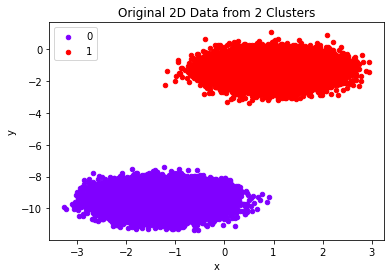

In [7]:
# scatter plot, data points annotated by different colors
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
cluster_name = set(y)
colors = dict(zip(cluster_name, cm.rainbow(np.linspace(0, 1, len(cluster_name)))))
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key].reshape(1,-1))
pyplot.title('Original 2D Data from {} Clusters'.format(n_components))
pyplot.show()

### Train a Logistic Regression Model

## Greadient Descent Optimizers

### Stochastic Gradient Descent (SGD)
### $\theta = \theta -  \eta \cdot \nabla_{\theta} J(θ) $

### Momentum

$\nu_{t} = \gamma \nu_{t-1} + \nabla_{\theta} J(θ)$

$\theta = \theta - \nu_{t}$

### Nesterov accelerated gradient

$\nu_{t} = \gamma \nu_{t-1} + \nabla_{\theta} J(θ - \gamma \nu_{t-1})$

$\theta = \theta - \nu_{t}$

or 

$\theta_{temp} = \theta_{t} - \gamma \nu_{t-1}$

$\theta_{t+1} = \theta_{temp} - \nabla_{\theta} J(θ)$

$\nu_{t} = \gamma \nu_{t-1} + \nabla_{\theta} J(θ)$

### Adagrad

$\theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{G_{t}+\epsilon}} \cdot g_{t}$

where $G_{t} \in \mathbb{R}^{d\times d}$ is a diagonal matrix where each diagonal element is the sum of the squares of the
gradients up to time step $t$.

### RMSprop

$E[g^{2}]_{t} = \beta E[g^{2}]_{t-1} + (1-\beta )g^{2}_{t}$

$\theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{E[g^{2}]_{t} +\epsilon}} \cdot g_{t}$

where $E[g^{2}]$ is an exponentially decaying average of squared gradients.

### Adam

$m_{t} = \beta_{1}m_{t-1}+(1-\beta_{1})g_{t}$

$\nu_{t} = \beta_{2} \nu_{t-1} + (1-\beta_{2})g^{2}_{t}$

$ \hat{m_{t}} =\frac{m_{t}}{1-\beta^{t}_{1}}$

$ \hat{\nu_{t}} =\frac{\nu_{t}}{1-\beta^{t}_{2}}$

$\theta_{t+1} = \theta_{t} - \frac{\eta}{\sqrt{\hat{\nu_{t}} +\epsilon}} \cdot \hat{m_{t}}$

reference: https://arxiv.org/pdf/1609.04747.pdf

In [8]:
# read X, y into rdd
rdd_X = sc.parallelize(X)
rdd_y = sc.parallelize(y)

# split data into train and test
# Add: map(lambda x: (x[0],np.append(x[1],1)))
traindata, testdata = rdd_y.zip(rdd_X).randomSplit([0.9, 0.1], seed=12345)
traindata.cache()

# Optimization 1: The dataset has additional parameters that will be used as the intercept
traindata1 = traindata.map(lambda x: (x[0],np.append(x[1],1)))
traindata1.cache()

PythonRDD[4] at RDD at PythonRDD.scala:53

In [9]:
print(traindata.take(1))
print(traindata1.take(1))

[(0, array([-1.18378037, -9.66095522]))]
[(0, array([-1.18378037, -9.66095522,  1.        ]))]


In [10]:
#1. Add
train_size = traindata.count()

In [11]:
# The original version of the code
def LogisticRegression(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       beta = 0.9,
                       beta2 = 0.999,
                       optimizer = 'SGD'  #optimizer: 'Momentum' / 'Adam' / 'Nesterov' / 'Adagrad' / 'RMSprop' / 'SGD' 
                      ):

    # initialization
    prev_cost = 0
    L_cost = []
    prev_validation = 0
    train_size = traindata.count()

    parameter_size = len(traindata.take(1)[0][1]) + 1
    np.random.seed(0)
    parameter_vector = np.random.normal(0, 0.1, parameter_size)
#     parameter_vector = np.zeros(parameter_size) # initialize with zeros
    momentum = np.zeros(parameter_size)
    prev_mom = np.zeros(parameter_size)
    second_mom = np.array(parameter_size)
    gti = np.zeros(parameter_size)
    epsilon = 10e-8
    
    for i in range(max_iteration):

        bc_weights = parameter_vector[:-1]
        bc1_weights = parameter_vector[-1]

        min_batch = traindata.sample(False, mini_batch_size / train_size, 1 + i)

        res = min_batch.treeAggregate((np.zeros(parameter_size), 0, 0),\
              lambda x, y:(x[0]\
                          + (np.append(y[1], 1)) * (-y[0] + (np.exp(np.dot(y[1], bc_weights) + bc1_weights)\
                          /(1 + np.exp(np.dot(y[1], bc_weights) + bc1_weights)))),\
                          x[1] \
                          + y[0] * (-(np.dot(y[1], bc_weights) + bc1_weights)) \
                          + np.log(1 + np.exp(np.dot(y[1],bc_weights)+ bc1_weights)),\
                          x[2] + 1),
              lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2]))

        cost =  res[1]/res[2] + regularization * (np.square(parameter_vector).sum())

        # calculate gradients
        gradient_derivative = (1.0 / res[2]) * res[0] + 2 * regularization * parameter_vector
        
        if optimizer == 'SGD':
            parameter_vector = parameter_vector - learningRate * gradient_derivative

        if optimizer =='Momentum':
            momentum = beta * momentum + learningRate * gradient_derivative
            parameter_vector = parameter_vector - momentum
            
        if optimizer == 'Nesterov':
            parameter_temp = parameter_vector - beta * prev_mom
            parameter_vector = parameter_temp - learningRate * gradient_derivative
            prev_mom = momentum
            momentum = beta * momentum + learningRate * gradient_derivative
            
        if optimizer == 'Adam':
            momentum = beta * momentum + (1 - beta) * gradient_derivative
            second_mom = beta2 * second_mom + (1 - beta2) * (gradient_derivative**2)
            momentum_ = momentum / (1 - beta**(i + 1))
            second_mom_ = second_mom / (1 - beta2**(i + 1))
            parameter_vector = parameter_vector - learningRate * momentum_ / (np.sqrt(second_mom_) + epsilon)

        if optimizer == 'Adagrad':
            gti += gradient_derivative**2
            adj_grad = gradient_derivative / (np.sqrt(gti)  + epsilon)
            parameter_vector = parameter_vector - learningRate  * adj_grad
        
        if optimizer == 'RMSprop':
            sq_grad = gradient_derivative**2
            exp_grad = beta * gti / (i + 1) + (1 - beta) * sq_grad
            parameter_vector = parameter_vector - learningRate / np.sqrt(exp_grad + epsilon) * gradient_derivative
            gti += sq_grad
            
        print("Iteration No.", i, " Cost=", cost)
        
        # Stop if the cost is not descreasing
        if abs(cost - prev_cost) < tolerance:
            print("cost - prev_cost: " + str(cost - prev_cost))
            break
        prev_cost = cost
        L_cost.append(cost)
        
    return parameter_vector, L_cost

In [12]:
# The optimised version of the code
def LogisticRegression_optimized(traindata=traindata,
                       max_iteration = max_iter,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       beta = 0.9,
                       beta2 = 0.999,
                       optimizer = 'SGD',  #optimizer: 'Momentum' / 'Adam' / 'Nesterov' / 'Adagrad' / 'RMSprop' / 'SGD' 
                       train_size=1
                      ):

    # initialization
    prev_cost = 0
    L_cost = []
    prev_validation = 0
    #1. Remove
    # train_size = traindata.count()

    # Optimization 2
    parameter_size = len(traindata.take(1)[0][1])
    np.random.seed(0)
    parameter_vector = np.random.normal(0, 0.1, parameter_size)
#     parameter_vector = np.zeros(parameter_size) # initialize with zeros
    momentum = np.zeros(parameter_size)
    prev_mom = np.zeros(parameter_size)
    second_mom = np.array(parameter_size)
    gti = np.zeros(parameter_size)
    epsilon = 10e-8
    
    for i in range(max_iteration):

        bc_weights = parameter_vector

        min_batch = traindata.sample(False, mini_batch_size / train_size, 1 + i)

        # Optimization - 3
        # res = min_batch.treeAggregate((np.zeros(parameter_size), 0, 0),\
        #       lambda x, y:(x[0]\
        #                   + (y[1]) * (-y[0] + (np.exp(np.dot(y[1], bc_weights))\
        #                   /(1 + np.exp(np.dot(y[1], bc_weights))))),\
        #                   x[1] \
        #                   + y[0] * (-(np.dot(y[1], bc_weights))) \
        #                   + np.log(1 + np.exp(np.dot(y[1],bc_weights))),\
        #                   x[2] + 1),
        #       lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2]))
        
        # Optimization 4
        res = min_batch.treeAggregate((np.zeros(parameter_size), 0, 0),\
              lambda x, y:(x[0]\
                          + (y[1]) * (-y[0] + (1/(np.exp(-np.dot(y[1], bc_weights))+1))),\
                          x[1] \
                          + y[0] * (-(np.dot(y[1], bc_weights))) \
                          + np.log(1 + np.exp(np.dot(y[1],bc_weights))),\
                          x[2] + 1),
              lambda x, y:(x[0] + y[0], x[1] + y[1], x[2] + y[2]))        

        gradients = res[0]
        sum_cost = res[1]
        num_samples = res[2]
        cost =  sum_cost/num_samples + regularization * (np.square(parameter_vector).sum())

        # calculate gradients
        gradient_derivative = (1.0 / num_samples) * gradients + 2 * regularization * parameter_vector
        
        if optimizer == 'SGD':
            parameter_vector = parameter_vector - learningRate * gradient_derivative

        if optimizer =='Momentum':
            momentum = beta * momentum + learningRate * gradient_derivative
            parameter_vector = parameter_vector - momentum
            
        if optimizer == 'Nesterov':
            parameter_temp = parameter_vector - beta * prev_mom
            parameter_vector = parameter_temp - learningRate * gradient_derivative
            prev_mom = momentum
            momentum = beta * momentum + learningRate * gradient_derivative
            
        if optimizer == 'Adam':
            momentum = beta * momentum + (1 - beta) * gradient_derivative
            second_mom = beta2 * second_mom + (1 - beta2) * (gradient_derivative**2)
            momentum_ = momentum / (1 - beta**(i + 1))
            second_mom_ = second_mom / (1 - beta2**(i + 1))
            parameter_vector = parameter_vector - learningRate * momentum_ / (np.sqrt(second_mom_) + epsilon)

        if optimizer == 'Adagrad':
            gti += gradient_derivative**2
            adj_grad = gradient_derivative / (np.sqrt(gti)  + epsilon)
            parameter_vector = parameter_vector - learningRate  * adj_grad
        
        if optimizer == 'RMSprop':
            sq_grad = gradient_derivative**2
            exp_grad = beta * gti / (i + 1) + (1 - beta) * sq_grad
            parameter_vector = parameter_vector - learningRate / np.sqrt(exp_grad + epsilon) * gradient_derivative
            gti += sq_grad
            
            
        print("Iteration No.", i, " Cost=", cost)
        
        # Stop if the cost is not descreasing
        if abs(cost - prev_cost) < tolerance:
            print("cost - prev_cost: " + str(cost - prev_cost))
            break
        prev_cost = cost
        L_cost.append(cost)
        
    return parameter_vector, L_cost

### Model Training

#### SGD

In [46]:
# Call to the original function
parameter_vector_sgd, L_cost_sgd = LogisticRegression(traindata=traindata,
                       max_iteration = 5,
                       learningRate = 0.01,
                       regularization = 0,
                       mini_batch_size = 50000,
                       tolerance = 10e-8,
                       optimizer = 'SGD',
                      )

Iteration No. 0  Cost= 0.5310081442378464
Iteration No. 1  Cost= 0.5077743594273991
Iteration No. 2  Cost= 0.489109059369825
Iteration No. 3  Cost= 0.4726070907340831
Iteration No. 4  Cost= 0.4610158334486895


In [47]:
# Call of the optimzed function wiht the same parameters
parameter_vector_sgd1, L_cost_sgd1 = LogisticRegression_optimized(traindata=traindata1,
                       max_iteration = 5,
                       learningRate = 0.01,
                       regularization = 0,
                       mini_batch_size = 50000,
                       tolerance = 10e-8,
                       optimizer = 'SGD',
                       train_size = train_size
                      )

Iteration No. 0  Cost= 0.5310081442378464
Iteration No. 1  Cost= 0.5077743594273991
Iteration No. 2  Cost= 0.489109059369825
Iteration No. 3  Cost= 0.4726070907340831
Iteration No. 4  Cost= 0.4610158334486895


#### Evaluate the model

In [52]:
# Test data need to be in the same format as the train data
testdata1 = testdata.map(lambda x: (x[0],np.append(x[1],1)))
test_num = testdata1.count()
testdata1.take(3)

[(1, array([ 0.69882203, -2.14009611,  1.        ])),
 (1, array([ 0.18499889, -1.20987419,  1.        ])),
 (1, array([ 0.65973693, -1.3079504 ,  1.        ]))]

In [53]:
# Parameter vector size and test sample size must match.
print(parameter_vector_sgd1)

[0.19726958 0.10068427 0.10116837]


In [49]:
# Create an RDD wiht the true value and the predicted value (true, predicted)
predictions = testdata1.map(lambda x: (x[0], 1 if np.dot(x[1],parameter_vector_sgd1)>0 else 0))

true_positive = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==1) else 0).reduce(lambda x,y:x+y)
false_positive = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==1) else 0).reduce(lambda x,y:x+y)

true_negative = predictions.map(lambda x: 1 if (x[0]== 0) and (x[1]==0) else 0).reduce(lambda x,y:x+y)
false_negative = predictions.map(lambda x: 1 if (x[0]== 1) and (x[1]==0) else 0).reduce(lambda x,y:x+y)

# Print the Contingency matrix
print("--Contingency matrix--")
print(f" TP:{true_positive:6}  FP:{false_positive:6}")
print(f" FN:{false_negative:6}  TN:{true_negative:6}")
print("----------------------")

# Calculate the Accuracy and the F1
accuracy = (true_positive+true_negative)/(test_num)
f1 = true_positive/(true_positive+0.5*(false_positive+false_negative))
print(f"Accuracy = {accuracy}  \nF1 = {f1}")

--Contingency matrix--
 TP:  4787  FP:     0
 FN:   289  TN:  4946
----------------------
Accuracy = 0.9711634404310517  
F1 = 0.9706985704146811


#### Adam

In [40]:
parameter_vector_adam, L_cost_adam = LogisticRegression(traindata=traindata,
                       max_iteration = 5,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       beta2 = 0.999,
                       optimizer = 'Adam'
                      )

Iteration No. 0  Cost= 0.5270205240293084
Iteration No. 1  Cost= 0.5292553279565456
Iteration No. 2  Cost= 0.5329195391918249
Iteration No. 3  Cost= 0.5280540593229041
Iteration No. 4  Cost= 0.5262573909668428


#### Momentum

In [41]:
parameter_vector_momentum, L_cost_momentum = LogisticRegression(traindata=traindata,
                       max_iteration = 5,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'Momentum'
                      )

Iteration No. 0  Cost= 0.5270205240293084
Iteration No. 1  Cost= 0.504932041203771
Iteration No. 2  Cost= 0.4752646219015988
Iteration No. 3  Cost= 0.43063867348580454
Iteration No. 4  Cost= 0.40347216232867783


#### Nesterov

In [42]:
parameter_vector_nesterov, L_cost_nesterov = LogisticRegression(traindata=traindata,
                       max_iteration = 5,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'Nesterov'
                      )

Iteration No. 0  Cost= 0.5270205240293084
Iteration No. 1  Cost= 0.504932041203771
Iteration No. 2  Cost= 0.4923548372979053
Iteration No. 3  Cost= 0.45376086108737446
Iteration No. 4  Cost= 0.42242465307313526


#### Adagrad

In [43]:
parameter_vector_adagrad, L_cost_adagrad = LogisticRegression(traindata=traindata,
                       max_iteration = 5,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'Adagrad'
                      )

Iteration No. 0  Cost= 0.5270205240293084
Iteration No. 1  Cost= 0.5104204638152968
Iteration No. 2  Cost= 0.5032269930693406
Iteration No. 3  Cost= 0.4883370568693622
Iteration No. 4  Cost= 0.4795339990009861


#### RMSprop

In [44]:
parameter_vector_rmsprop, L_cost_rmsprop = LogisticRegression(traindata=traindata,
                       max_iteration = 5,
                       learningRate = 0.01,
                       regularization = 0.01,
                       mini_batch_size = 512,
                       tolerance = 10e-8,
                       optimizer = 'RMSprop'
                      )

Iteration No. 0  Cost= 0.5270205240293084
Iteration No. 1  Cost= 0.4724224256645872
Iteration No. 2  Cost= 0.46022064012841146
Iteration No. 3  Cost= 0.4381317471022344
Iteration No. 4  Cost= 0.4238202858995442


### Optimizers Comparison

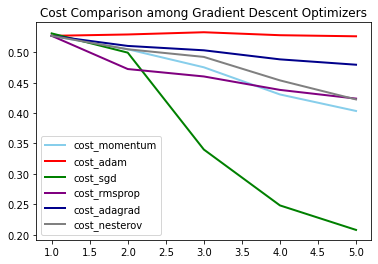

In [45]:
# Data
df = pd.DataFrame({'iteration': range(1, 5+1), 
                     'cost_momentum': L_cost_momentum, 
                     'cost_adam': L_cost_adam, 
                     'cost_sgd': L_cost_sgd,
                     'cost_rmsprop': L_cost_rmsprop,
                     'cost_adagrad': L_cost_adagrad,
                     'cost_nesterov': L_cost_nesterov})
 
# multiple line plots
pyplot.plot( 'iteration', 'cost_momentum', data=df, marker='', color='skyblue', linewidth=2)
pyplot.plot( 'iteration', 'cost_adam', data=df, marker='', color='red', linewidth=2)
pyplot.plot( 'iteration', 'cost_sgd', data=df, marker='', color='green', linewidth=2)
pyplot.plot( 'iteration', 'cost_rmsprop', data=df, marker='', color='purple', linewidth=2)
pyplot.plot( 'iteration', 'cost_adagrad', data=df, marker='', color='darkblue', linewidth=2)
pyplot.plot( 'iteration', 'cost_nesterov', data=df, marker='', color='grey', linewidth=2)
# show legend
pyplot.legend()
pyplot.title('Cost Comparison among Gradient Descent Optimizers')
# show graph
pyplot.show()